# Important!
When initially opening the notebook there should be a text to the right of the "Help" menu saying "Changes will not be saved".
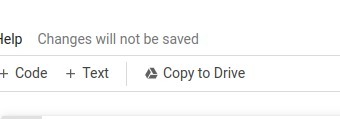

To ensure you can make changes to the notebook save a copy of it to your own drive and work on that one. You can do that by going to "File" -> "Save a copy in Drive".

**Failing to do so will result in code loss!**

 **Note** Make sure you are the only one that has access to it!


In [1]:
#@markdown #Image Processing - 67829. { display-mode: "form" }
#@markdown ##Exercise 5:  Deep Style Image Prior
#@markdown ##Due date: 6.02.2025 at 23:59
#@title{ display-mode: "form" }

#@markdown
#@markdown This exercise is a bit different than the rest of the exercises in the course.
#@markdown The submissions will be a PDF file with your answers and results to the exercise
#@markdown as well as some files so that we can verify the authenticity of your results.
#@markdown This notebook provides the basic code, but you do not need to adhere to some specific API
#@markdown and we will not be running unit tests on your code.
#@markdown We will however, be going over your code and running it manually.
#@markdown Moreover, we will be running tests to ensure the authenticity of your solution and detect plagiarism
#@markdown
#@markdown
#@markdown Before you start working on the exercise it is recommended that you review the lecture slides covering neural networks,
#@markdown
#@markdown
#@markdown **NOTE**: Neural networks are typically trained on GPUs, without GPUs training takes much longer.
#@markdown To enable GPU tranining click on "Runtime" -> "Change runtime type" -> "GPU" -> "SAVE".
#@markdown
#@markdown **NOTE**: A short guide on debugging your code using colab is availble [here](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.06-Errors-and-Debugging.ipynb#scrollTo=qnIn-rWFqoww).

#@markdown But first, we have to download all of the dependencies and install them.
#@markdown Play this cell to download it and get everything ready. markdown This may take a few minutes.


!mkdir impr_ex5_resources
%cd impr_ex5_resources
#!wget "https://www.cs.huji.ac.il/~impr/shape_predictor_68_face_landmarks.dat" -O shape_predictor_68_face_landmarks.dat
#!wget "https://www.cs.huji.ac.il/~impr/align_faces.py" -O align_faces.py
# !wget "https://www.cs.huji.ac.il/w~impr/stylegan2-ada-pytorch.tar" -O stylegan2-ada-pytorch.tar
!wget -v --max-redirect=5 --user-agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"  "https://www.cs.huji.ac.il/w~impr/stylegan2-ada-pytorch.tar" -O stylegan2-ada-pytorch.tar
!tar -xvf stylegan2-ada-pytorch.tar
!rm -f stylegan2-ada-pytorch.tar

import sys
ROOT_PATH="/content/impr_ex5_resources/stylegan2-ada-pytorch"
sys.path.append(ROOT_PATH)


!pip install ninja
!pip install mediapy
!pip install
CHECKPOINTS_PATH = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"
!pip install opencv-python


import copy
import os
from time import perf_counter
import click
import imageio
import numpy as np
import PIL.Image
import torch
import torch.nn.functional as F

import dnnlib
import legacy
import numpy as np
from skimage.draw import line
from torch.nn.functional import conv2d,conv1d
import mediapy as media
from IPython.display import clear_output
import matplotlib.pyplot as plt


/content/impr_ex5_resources
--2025-05-19 06:05:05--  https://www.cs.huji.ac.il/w~impr/stylegan2-ada-pytorch.tar
Resolving www.cs.huji.ac.il (www.cs.huji.ac.il)... 128.139.7.26
Connecting to www.cs.huji.ac.il (www.cs.huji.ac.il)|128.139.7.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-tar]
Saving to: ‘stylegan2-ada-pytorch.tar’

stylegan2-ada-pytor     [               <=>  ]  95.66M   284KB/s    in 5m 11s  

2025-05-19 06:10:17 (315 KB/s) - ‘stylegan2-ada-pytorch.tar’ saved [100311040]

stylegan2-ada-pytorch/
stylegan2-ada-pytorch/metrics/
stylegan2-ada-pytorch/metrics/._precision_recall.py
stylegan2-ada-pytorch/metrics/precision_recall.py
stylegan2-ada-pytorch/metrics/._frechet_inception_distance.py
stylegan2-ada-pytorch/metrics/frechet_inception_distance.py
stylegan2-ada-pytorch/metrics/.___init__.py
stylegan2-ada-pytorch/metrics/__init__.py
stylegan2-ada-pytorch/metrics/._metric_utils.py
stylegan2-ada-pytorch/metrics/metric_uti

# Mounting Google Drive

In [2]:
#@markdown **NOTE**: It is strongly advised you save your results to Google
#@markdown Drive as they will be deleted from Colab once it restarts.
#@markdown To connect Google Drive run this cell.
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Below is the root dir of your Google Drive. To choose the destenation of the dir to save and read from, create it in your Google Drive and add the relative path to the "GDRIVE_SAVE_REL_PATH" variable below.

In [3]:
ROOT_GDRIVE_PATH="/content/gdrive/MyDrive/"
GDRIVE_SAVE_REL_PATH = "/IMPR/ex5/"
FULL_GDRIVE_SAVE_PATH = ROOT_GDRIVE_PATH + GDRIVE_SAVE_REL_PATH

# General Variables

In [4]:
GAUSSIAN_BLUR_DEGRADATION= 'GAUSSIAN_BLUR_DEGRADATION'
GRAYSCALE_DEGRADATION = 'GRAYSCALE_DEGRADATION'
INPAINTING_DEGRADATION = 'INPAINTING_DEGRADATION'
NO_DEGRADATION= 'NO_DEGRADATION'



# Image Alignment

In [5]:
# The align_faces.py script takes in an input image path, an output image path, and a dat file path. The dat file is already downloaded for you, so leave it as it is.
# It is advised that you save the files to google drive as restarting Colab will erase them.
!python "$ROOT_PATH/align_faces/align_faces.py" '/content/gdrive/MyDrive/IMPR/ex5/Wedding_image_Amir.jpg' '/content/gdrive/MyDrive/IMPR/ex5/Wedding_image_Amir_Aligned.jpg' "$ROOT_PATH/align_faces/shape_predictor_68_face_landmarks.dat"

Number of faces detected: 1
Detection 0: Left: 656 Top: 1119 Right: 1118 Bottom: 1581
Part 0: (676, 1255), Part 1: (677, 1311) ...


# Degradation Functions

In [6]:
    # ********************************************************************************************************
    # ******************                   NEED TO ADD DEGRADATION FUNCTIONS                ******************
    # ********************************************************************************************************

In [7]:
import torch
import math
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from IPython import get_ipython
from IPython.display import display
import cv2

def apply_gaussian_blur_cv2(image, kernel_size=5, sigma=1.0, device=torch.device('cuda')):
    # Image shape: [N, C, H, W] or [C, H, W]
    if len(image.shape) == 3:
        image = image.unsqueeze(0)  # Add batch dimension
    assert len(image.shape) == 4, f"Expected 4D input, got shape {image.shape}"

    # Convert to NumPy: [N, C, H, W] -> [N, H, W, C]
    image_np = image.permute(0, 2, 3, 1).cpu().numpy()

    # Apply cv2.GaussianBlur to each image in the batch
    blurred_np = np.zeros_like(image_np)
    for i in range(image_np.shape[0]):
        # cv2 expects [H, W, C], sigmaX=sigma, sigmaY=sigma
        blurred_np[i] = cv2.GaussianBlur(image_np[i], (kernel_size, kernel_size), sigmaX=sigma, sigmaY=sigma)

    # Convert back to PyTorch: [N, H, W, C] -> [N, C, H, W]
    blurred_tensor = torch.tensor(blurred_np, device=device, dtype=torch.float32).permute(0, 3, 1, 2)

    assert blurred_tensor.shape == image.shape, f"Output shape {blurred_tensor.shape} does not match input {image.shape}"
    return blurred_tensor

def apply_gaussian_blur_for_run_latent_optimization(image, kernel_size=5, sigma=1.0, device=torch.device('cuda')):
    if len(image.shape) == 3:
      image = image.unsqueeze(0)
    assert len(image.shape) == 4, f"Expected 4D input, got shape {image.shape}"
    channels = image.shape[1]
    x = torch.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1., device=device)
    y = torch.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1., device=device)
    x, y = torch.meshgrid(x, y, indexing='ij')
    kernel = torch.exp(-(x**2 + y**2) / (2. * sigma**2))
    kernel = kernel / kernel.sum()
    kernel = kernel.view(1, 1, kernel_size, kernel_size).repeat(channels, 1, 1, 1)
    padding = kernel_size // 2
    output = torch.nn.functional.conv2d(image, kernel, padding=padding, groups=channels)
    assert output.shape == image.shape, f"Output shape {output.shape} does not match input {image.shape}"
    return output


# Grayscale conversion function
def apply_grayscale(image, device=torch.device('cuda')):
    """
    Convert an RGB image to grayscale with 3 channels.
    Input: [N, C, H, W] or [C, H, W], C=3, RGB image
    Output: Same shape, grayscale (repeated across 3 channels)
    """
    if len(image.shape) == 3:
        image = image.unsqueeze(0)
    assert len(image.shape) == 4 and image.shape[1] == 3, f"Expected [N, 3, H, W], got {image.shape}"

    # Luminance formula: 0.299R + 0.587G + 0.114B
    weights = torch.tensor([0.299, 0.587, 0.114], device=device).view(1, 3, 1, 1)
    grayscale = (image * weights).sum(dim=1, keepdim=True)  # [N, 1, H, W]
    grayscale = grayscale.repeat(1, 3, 1, 1)  # [N, 3, H, W]
    assert grayscale.shape == image.shape, f"Output shape {grayscale.shape} does not match input {image.shape}"
    return grayscale

    # Mask creation function
def create_mask(image_shape, mask_type='rectangle', device=torch.device('cuda')):
    """
    Create a binary mask for inpainting.
    Args:
        image_shape (tuple): Shape of the image [N, C, H, W] or [C, H, W].
        mask_type (str): Type of mask ('rectangle' for now).
        device: Torch device.
    Returns:
        torch.Tensor: Binary mask (1 for unmasked, 0 for masked).
    """
    if len(image_shape) == 3:
        image_shape = (1,) + image_shape
    N, C, H, W = image_shape
    mask = torch.ones(N, 1, H, W, device=device, dtype=torch.float32)  # 1 for unmasked

    if mask_type == 'rectangle':
        # Create a rectangular mask over part of the image (e.g., lower-right quadrant)
        mask_height = H // 4
        mask_width = W // 4
        mask[:, :, H - (3*mask_height): H - (2*mask_height), W - (3*mask_width):W - (2*mask_width)] = 0  # Set to 0 (masked)

    return mask.repeat(1, C, 1, 1)  # Repeat across channels

# Apply mask function
def apply_mask(image, mask, device=torch.device('cuda')):
    """
    Apply a binary mask to an image.
    Args:
        image (torch.Tensor): Image tensor [N, C, H, W] or [C, H, W].
        mask (torch.Tensor): Binary mask [N, C, H, W].
        device: Torch device.
    Returns:
        torch.Tensor: Masked image.
    """
    if len(image.shape) == 3:
        image = image.unsqueeze(0)
    assert len(image.shape) == 4, f"Expected 4D input, got shape {image.shape}"
    assert image.shape == mask.shape, f"Image shape {image.shape} must match mask shape {mask.shape}"
    return image * mask

# GAN Inversion

In [8]:
def run_latent_optimization(outdir,
    degradation_mode,
    G,
    imgs_to_disply_dict,
    target: torch.Tensor, # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
    *,
    num_steps                  = 1000,
    w_avg_samples              = 10000,
    initial_learning_rate      = 0.1,
    initial_noise_factor       = 0.05,
    lr_rampdown_length         = 0.25,
    lr_rampup_length           = 0.05,
    noise_ramp_length          = 0.75,
    regularize_noise_weight    = 1e5,
    latent_dist_reg_weight     = 0.001,
    device: torch.device

):
    losses = []
    assert target.shape == (G.img_channels, G.img_resolution, G.img_resolution)

    G = copy.deepcopy(G).eval().requires_grad_(False).to(device) # type: ignore

    # Compute w stats.
    print(f'Computing W midpoint and stddev using {w_avg_samples} samples...')
    z_samples = np.random.RandomState(123).randn(w_avg_samples, G.z_dim)
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
    w_samples = w_samples.cpu().numpy().astype(np.float32)
    w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 18, C]
    w_avg_original = torch.from_numpy(w_avg).to(device).float()
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

    # Setup noise inputs.
    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

    # Load VGG16 feature detector.
    url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
    with dnnlib.util.open_url(url) as f:
        vgg16 = torch.jit.load(f).eval().to(device)

    # Features for target image.
    target_images = target.unsqueeze(0).to(device).to(torch.float32)

    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    target_features = vgg16(target_images, resize_images=False, return_lpips=True)

    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True)
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)

    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True

    for step in range(num_steps):
        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Synth image from opt_w
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = w_opt + w_noise
        synth_images = G.synthesis(ws, noise_mode='const')

        # Save non-degraded image (sharp)
        synth_image_save = (synth_images + 1) * (255/2)
        synth_image_save = synth_image_save.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

        degraded_images = synth_images
        # ********************************************************************************************************
        # ******************                   NEED TO FILL IN THE FOLLOWING CODE               ******************
        # ********************************************************************************************************
        if  degradation_mode == INPAINTING_DEGRADATION:
          mask = create_mask(synth_images.shape, mask_type='rectangle', device=device)
          degraded_images = apply_mask(synth_images, mask, device=device)
        elif degradation_mode == GRAYSCALE_DEGRADATION:
          degraded_images = apply_grayscale(synth_images, device=device)
        elif degradation_mode == GAUSSIAN_BLUR_DEGRADATION:
          degraded_images = apply_gaussian_blur_for_run_latent_optimization(synth_images, kernel_size=21, sigma=6.0, device=device)
        # ********************************************************************************************************
        # ******************                          END CODE TO ADD SECTION                   ******************
        # ********************************************************************************************************


        # Prep to save and show images
        synth_image_degraded_save = (degraded_images + 1) * (255/2)
        synth_image_degraded_save = synth_image_degraded_save.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

        if step % 20 == 0:
          imgs_to_disply_dict["Generated Image"]=synth_image_save
          imgs_to_disply_dict["Generated Degraded Image"]=synth_image_degraded_save
          clear_output(wait=True)
          media.show_images(imgs_to_disply_dict,height=256)
        if step % 100 == 0:
          PIL.Image.fromarray(synth_image_save, 'RGB').save(f'{outdir}/intermidiate_%d_not_degraded.png'%step)
          PIL.Image.fromarray(synth_image_degraded_save, 'RGB').save(f'{outdir}/intermidiate_%d_degraded.png'%step)


        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        degraded_images = (degraded_images + 1) * (255/2)
        if degraded_images.shape[2] > 256:
            degraded_images = F.interpolate(degraded_images, size=(256, 256), mode='area')

        # Features for synth images.
        synth_features = vgg16(degraded_images, resize_images=False, return_lpips=True)

        # Compute loss
        percep_loss = (target_features - synth_features).square().sum()
        latent_dist_reg = F.l1_loss(w_avg_original, w_opt)
        loss = percep_loss + reg_loss * regularize_noise_weight  + latent_dist_reg_weight * latent_dist_reg
        losses.append(float(loss))


        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
          print(f'step {step+1:>4d}/{num_steps}: percep_loss {percep_loss:<4.2f} latent_dist_reg {latent_dist_reg:<4.2f} loss {float(loss):<5.2f}' )

        # Save inverted latent for each optimization step.
        w_out[step] = w_opt.detach()[0]

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()

    plt.plot(range(1, num_steps + 1), losses)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Optimization Loss')
    plt.grid(True)
    plt.savefig(f'{outdir}/loss_plot.png')
    plt.show()
    return w_out

In [9]:

def invert_image(degradation_mode,
                   target_fname,
                   outdir,
                   seed=303,
                   num_steps=1000,
                   latent_dist_reg_weight=0.001):
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Load networks.
    print('Loading networks from "%s"...' % CHECKPOINTS_PATH)
    device = torch.device('cuda')
    with dnnlib.util.open_url(CHECKPOINTS_PATH) as fp:
        networks = legacy.load_network_pkl(fp)
        G = networks['G_ema'].requires_grad_(False).to(device)


    # Load target image.
    if not os.path.exists(outdir):
      os.makedirs(outdir)
    target_pil = PIL.Image.open(target_fname).convert('RGB')
    w, h = target_pil.size
    s = min(w, h)
    target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
    target_pil = target_pil.resize((G.img_resolution, G.img_resolution), PIL.Image.LANCZOS)
    target_uint8 = np.array(target_pil, dtype=np.uint8)
    target = torch.tensor(target_uint8.transpose([2, 0, 1]), device=device).unsqueeze(0).to(torch.float32)

    # Validate target shape
    assert target.shape == (1, G.img_channels, G.img_resolution, G.img_resolution), f"Target shape {target.shape} mismatches expected (1, {G.img_channels}, {G.img_resolution}, {G.img_resolution})"

    # Save original image before degradation
    original_to_save = target.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    PIL.Image.fromarray(original_to_save, 'RGB').save(f'{outdir}/original_image.png')

    # ********************************************************************************************************
    # ******************                   NEED TO FILL IN THE FOLLOWING CODE               ******************
    # ********************************************************************************************************
    if  degradation_mode == INPAINTING_DEGRADATION:
      mask = create_mask(target.shape, mask_type='rectangle', device=device)
      target = apply_mask(target, mask, device=device)
    elif degradation_mode == GRAYSCALE_DEGRADATION:
      if 'alan_turing' not in target_fname.lower():
            target = apply_grayscale(target, device=device)
    elif degradation_mode == GAUSSIAN_BLUR_DEGRADATION:
      if 'yann_lecun' not in target_fname.lower():
        target = apply_gaussian_blur_cv2(target, kernel_size=21, sigma=6.0, device=device)
    # ********************************************************************************************************
    # ******************                          END CODE TO ADD SECTION                   ******************
    # ********************************************************************************************************

    #Save target image
    target_to_save = target.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    PIL.Image.fromarray(target_to_save, 'RGB').save(f'{outdir}/original_degraded_image.png')
    imgs_to_disply_dict = {
        "Original Image":target_uint8,
        "Original Degraded Image":target_to_save,
              }

    # Run latent optimization
    start_time = perf_counter()
    optimization_steps = run_latent_optimization(
        outdir,
        degradation_mode,
        G,
        imgs_to_disply_dict,
        target[0],
        num_steps=num_steps,
        device=device,
        latent_dist_reg_weight=latent_dist_reg_weight
    )

    print (f'Elapsed: {(perf_counter()-start_time):.1f} s')
    os.makedirs(outdir, exist_ok=True)

    # Save final inverted image and latent vector.
    inverted_latent = optimization_steps[-1]
    synth_image = G.synthesis(inverted_latent.unsqueeze(0), noise_mode='const')
    synth_image = (synth_image + 1) * (255/2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    PIL.Image.fromarray(synth_image, 'RGB').save(f'{outdir}/final_inverted_image.png')
    # plot the final inverted image
    plt.imshow(synth_image)
    plt.title('Final Inverted Image')
    plt.axis('off')
    plt.savefig(f'{outdir}/final_inverted_image_plot.png')
    plt.show()
    np.savez(f'{outdir}/inverted_latent.npz', latent=inverted_latent.unsqueeze(0).cpu().numpy())


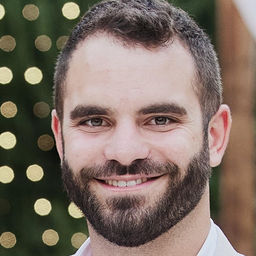
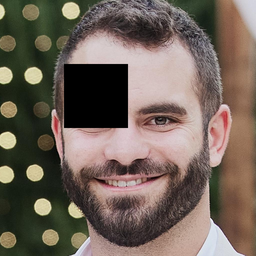
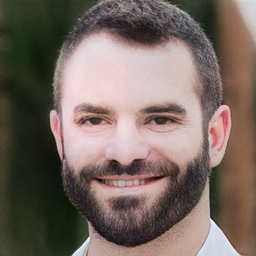
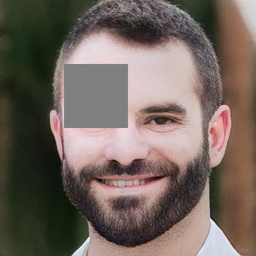

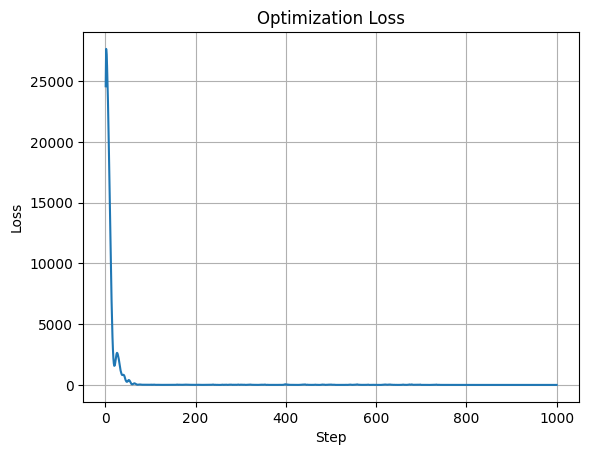

Elapsed: 265.9 s


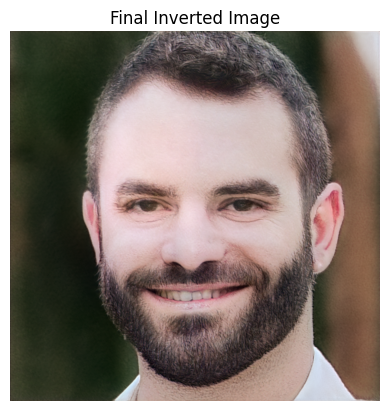

In [14]:
from google.colab import drive
drive.mount('/content/gdrive/')
target_fname = '/content/gdrive/MyDrive/IMPR/ex5/Wedding_image_Amir_Aligned.jpg'
outdir = '/content/gdrive/MyDrive/IMPR/ex5/output_3_3_3_wedding'
os.makedirs(outdir, exist_ok=True)
invert_image(degradation_mode=INPAINTING_DEGRADATION,
             target_fname=target_fname,
             outdir=outdir,
             seed=303,
             num_steps=1000,
             latent_dist_reg_weight=0.01)


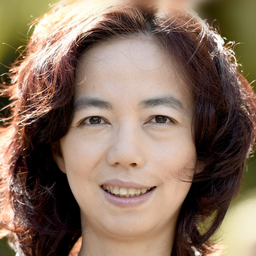
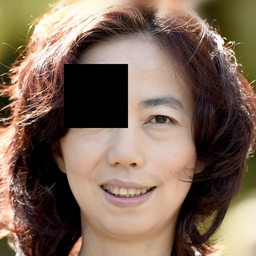
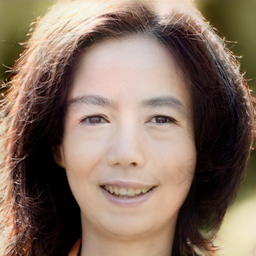
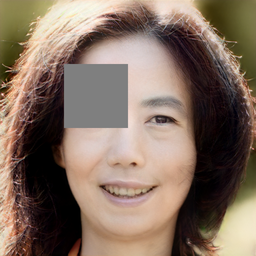

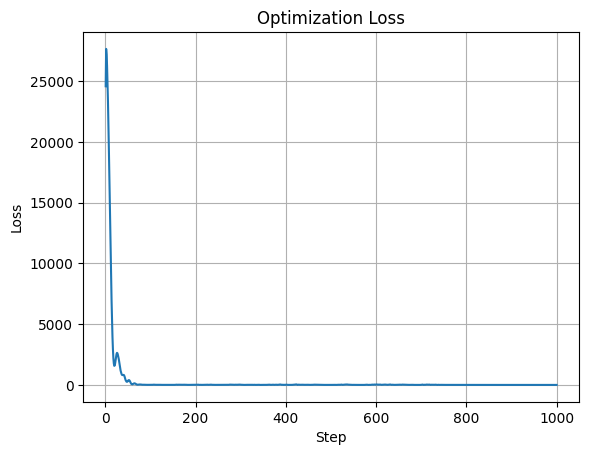

Elapsed: 264.4 s


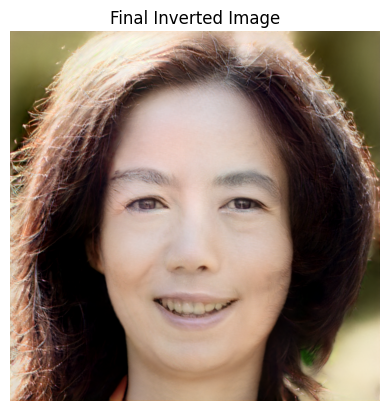

In [15]:
from google.colab import drive
drive.mount('/content/gdrive/')
target_fname = '/content/gdrive/MyDrive/IMPR/ex5/fei_fei_li_original.png'
outdir = '/content/gdrive/MyDrive/IMPR/ex5/output_3_3_3_fei'
os.makedirs(outdir, exist_ok=True)
invert_image(degradation_mode=INPAINTING_DEGRADATION,
             target_fname=target_fname,
             outdir=outdir,
             seed=303,
             num_steps=1000,
             latent_dist_reg_weight=0.01)


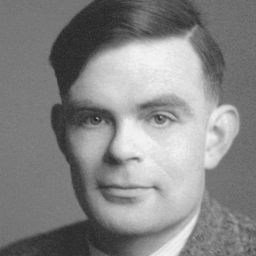
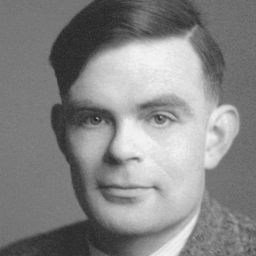
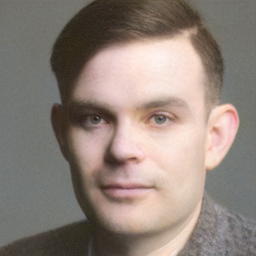
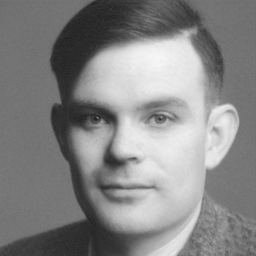

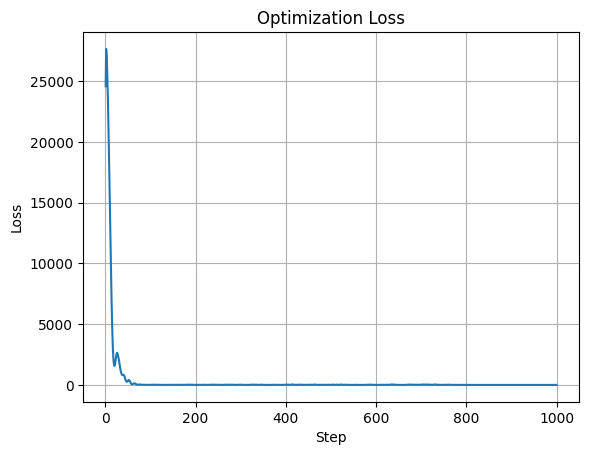

Elapsed: 265.2 s


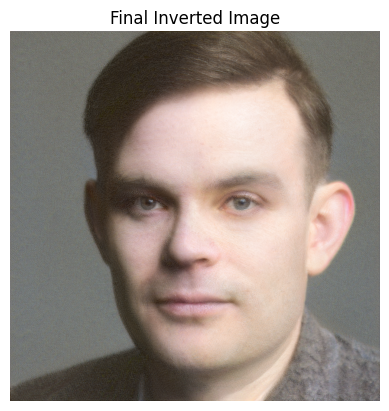

In [16]:
from google.colab import drive
drive.mount('/content/gdrive/')
target_fname = '/content/gdrive/MyDrive/IMPR/ex5/alan_turing_grayscale.png'
outdir = '/content/gdrive/MyDrive/IMPR/ex5/output_3_3_2_alan'
os.makedirs(outdir, exist_ok=True)
invert_image(degradation_mode=GRAYSCALE_DEGRADATION,
             target_fname=target_fname,
             outdir=outdir,
             seed=303,
             num_steps=1000,
             latent_dist_reg_weight=0.5)


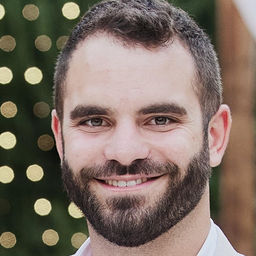
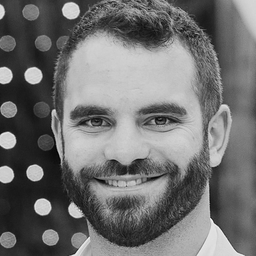
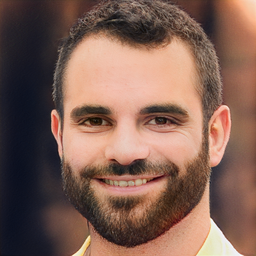
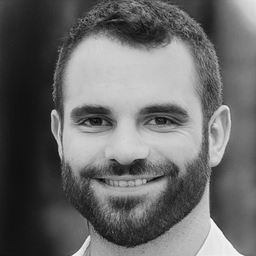

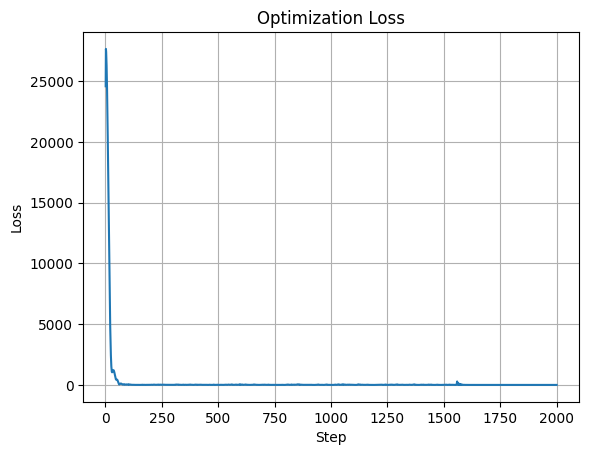

Elapsed: 529.1 s


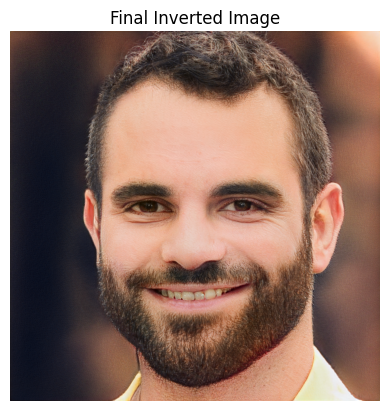

In [18]:
from google.colab import drive
drive.mount('/content/gdrive/')
target_fname = '/content/gdrive/MyDrive/IMPR/ex5/Wedding_image_Amir_Aligned.jpg'
outdir = '/content/gdrive/MyDrive/IMPR/ex5/output_3_3_2_wedding'
os.makedirs(outdir, exist_ok=True)
invert_image(degradation_mode=GRAYSCALE_DEGRADATION,
             target_fname=target_fname,
             outdir=outdir,
             seed=303,
             num_steps=2000,
             latent_dist_reg_weight=0.5)


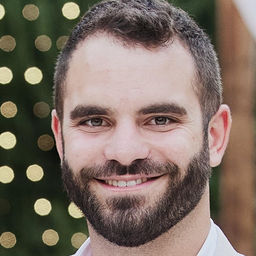
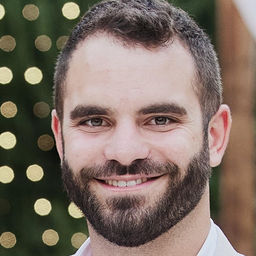
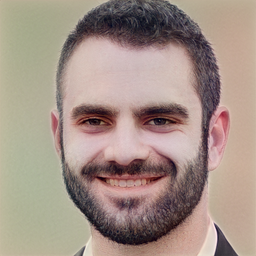
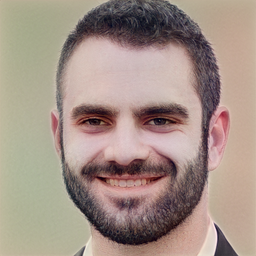

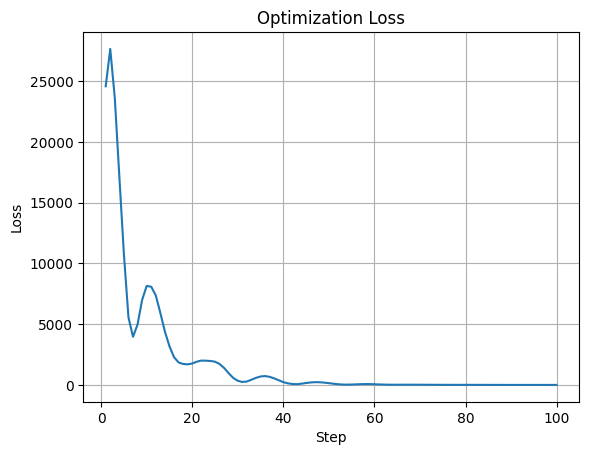

Elapsed: 31.3 s


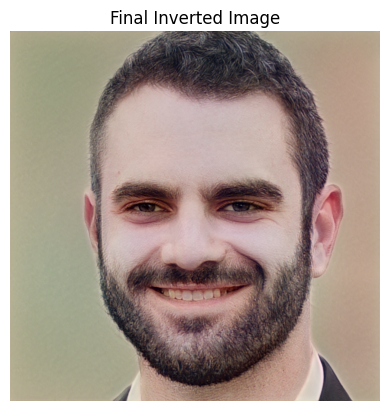

In [20]:
target_fname='/content/gdrive/MyDrive/IMPR/ex5/Wedding_image_Amir_Aligned.jpg'
outdir='/content/gdrive/MyDrive/IMPR/ex5/Wedding_image_output_3_2'
for num_steps in [1000, 500, 100]:
    for reg in [0.1, 0.0001]:
        outdir = f'/content/gdrive/MyDrive/IMPR/ex5/output_3_2_steps{num_steps}_reg{reg}'
        invert_image(degradation_mode=NO_DEGRADATION,
                     target_fname=target_fname,
                     outdir=outdir,
                     num_steps=num_steps,
                     latent_dist_reg_weight=reg)


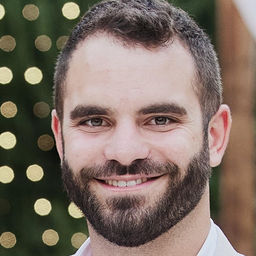
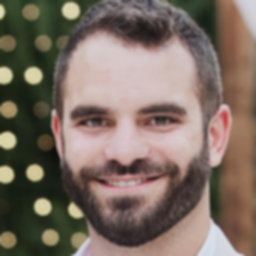
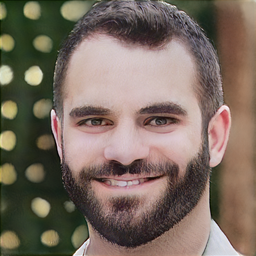
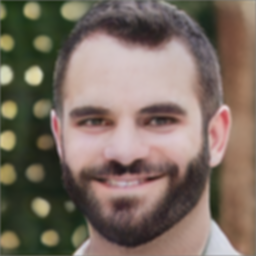

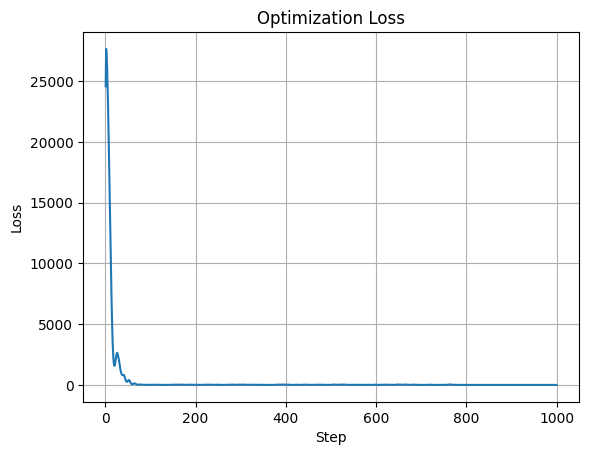

Elapsed: 291.8 s


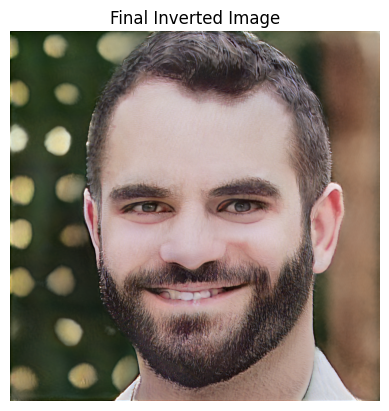

In [21]:
from google.colab import drive
drive.mount('/content/gdrive/')
target_fname = '/content/gdrive/MyDrive/IMPR/ex5/Wedding_image_Amir_Aligned.jpg'
outdir = '/content/gdrive/MyDrive/IMPR/ex5/output_3_3_1'
os.makedirs(outdir, exist_ok=True)
invert_image(degradation_mode=GAUSSIAN_BLUR_DEGRADATION,
             target_fname=target_fname,
             outdir=outdir,
             seed=303,
             num_steps=1000,
             latent_dist_reg_weight=0.001)


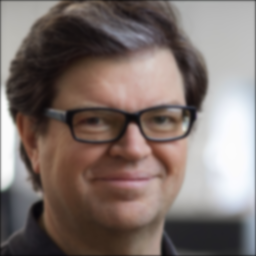
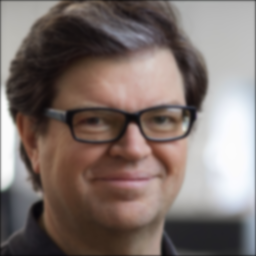
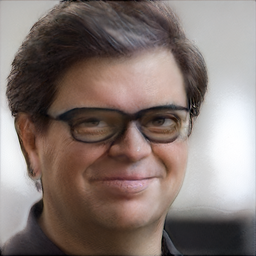
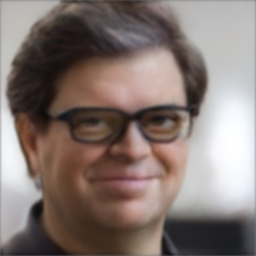

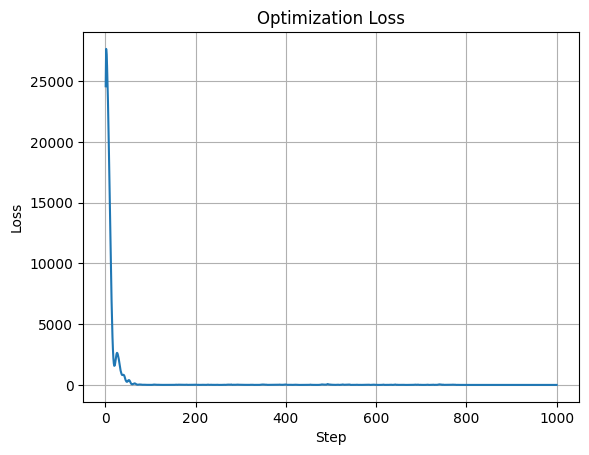

Elapsed: 286.3 s


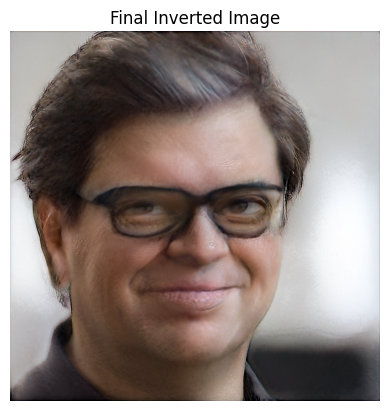

In [22]:
yann_fname = '/content/gdrive/MyDrive/IMPR/ex5/yann_lecun_blur.png'
yann_outdir = '/content/gdrive/MyDrive/IMPR/ex5/output_3_3_1_yann'
os.makedirs(yann_outdir, exist_ok=True)
invert_image(degradation_mode=GAUSSIAN_BLUR_DEGRADATION,
             target_fname=yann_fname,
             outdir=yann_outdir,
             seed=303,
             num_steps=1000,
             latent_dist_reg_weight=0.001)

In [ ]:
for kernel_size, sigma in [(3, 0.5), (5, 1.0), (7, 2.0)]:
    outdir = f'/content/gdrive/MyDrive/IMPR/ex5/output_3_3_1_kernel{kernel_size}_sigma{sigma}'
    def modified_apply_gaussian_blur(image, kernel_size=kernel_size, sigma=sigma, device=device):
        return apply_gaussian_blur(image, kernel_size, sigma, device)
    # Temporarily override apply_gaussian_blur in invert_image and run_latent_optimization
    invert_image(degradation_mode=GAUSSIAN_BLUR_DEGRADATION,
                 target_fname=target_fname,
                 outdir=outdir,
                 seed=303,
                 num_steps=1000,
                 latent_dist_reg_weight=0.001)

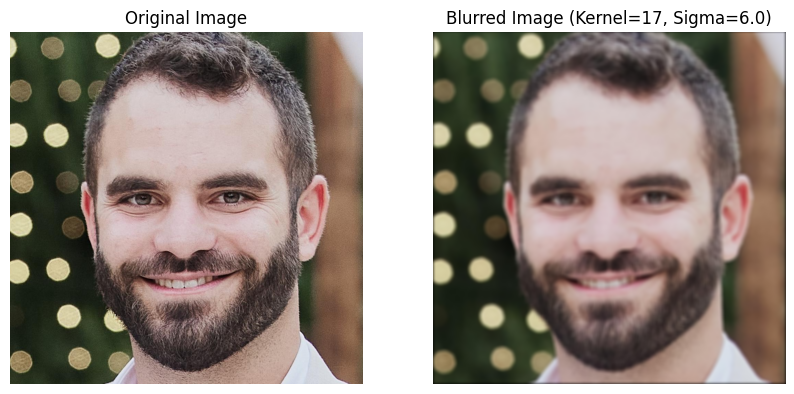

In [ ]:
def plot_image_and_blur(image_path, kernel_size=17, sigma=6.0):
    # Load the image
    image_path = '/content/gdrive/MyDrive/IMPR/ex5/Wedding_image_Amir_Aligned.jpg'
    original_image = Image.open(image_path).convert('RGB')
    original_image_np = np.array(original_image)

    # Convert to tensor
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    image_tensor = torch.tensor(original_image_np.transpose([2, 0, 1]), dtype=torch.float32, device=device)
    image_tensor = image_tensor.unsqueeze(0)  # Shape: [1, C, H, W]

    # Apply Gaussian blur
    blurred_image_tensor = apply_gaussian_blur_for_run_latent_optimization(
        image_tensor,
        kernel_size=kernel_size,
        sigma=sigma,
        device=device
    )
    blurred_image_np = blurred_image_tensor.squeeze(0).permute(1, 2, 0).clamp(0, 255).to(torch.uint8).cpu().numpy()

    # Plot the images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image_np)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(blurred_image_np)
    plt.title(f"Blurred Image (Kernel={kernel_size}, Sigma={sigma})")
    plt.axis('off')

    plt.show()

# Example usage
plot_image_and_blur('/content/drive/MyDrive/IMPR/ex5/Wedding_image_Amir_Aligned.jpg')

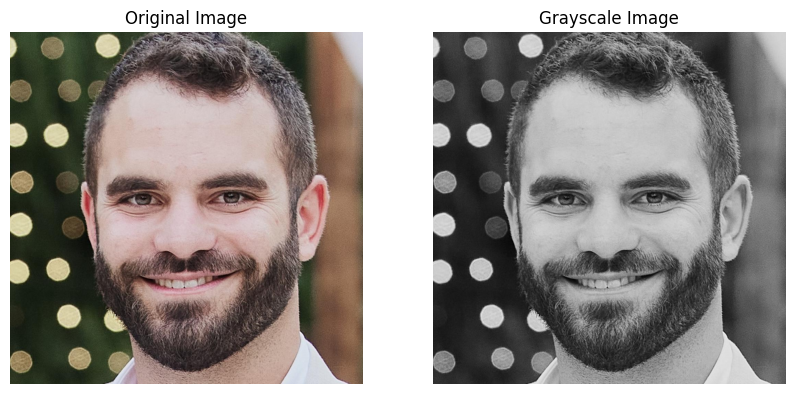

In [ ]:
def plot_image_and_grayscale(image_path):
    """
    Load an image, apply grayscale conversion, and plot the original and grayscale images.
    Args:
        image_path (str): Path to the input image.
    """
    # Load the image
    image_path = '/content/gdrive/MyDrive/IMPR/ex5/Wedding_image_Amir_Aligned.jpg'
    original_image = Image.open(image_path).convert('RGB')
    original_image_np = np.array(original_image)

    # Convert to tensor
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    image_tensor = torch.tensor(original_image_np.transpose([2, 0, 1]), dtype=torch.float32, device=device)
    image_tensor = image_tensor.unsqueeze(0)  # Shape: [1, C, H, W]

    # Apply grayscale conversion
    grayscale_image_tensor = apply_grayscale(image_tensor, device=device)
    grayscale_image_np = grayscale_image_tensor.squeeze(0).permute(1, 2, 0).clamp(0, 255).to(torch.uint8).cpu().numpy()

    # Plot the images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image_np)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(grayscale_image_np)
    plt.title("Grayscale Image")
    plt.axis('off')

    plt.show()

# Example usage
plot_image_and_grayscale('/content/drive/MyDrive/IMPR/ex5/Wedding_image_Amir_Aligned.jpg')